In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# set definitions
T,TT,TTT,TTTx = gl.data_loader()

gl.thickness_renamer(T)
gl.thickness_renamer(TT)

glathida_list = T,TT,TTT,TTTx
# ,TTT,TTTx

T.name = 'T'
TT.name = 'TT'
TTT.name = 'TTT'
TTTx.name = 'TTTx'

pth_model = '/home/sa42/notebooks/glac/saved_models/'
pth_res = '/home/sa42/notebooks/glac/saved_results/'

In [4]:
# load models
linear_model = {}
dnn_model = {}
for i in glathida_list:
    (train_features, test_features, train_labels, test_labels) = gl.data_splitter(i)
    for variable_name in list(train_features) + ['MULTI']:
        file_name = pth_model + i.name + '_linear_' + variable_name
#         print(file_name)
        linear_model[i.name + '_' + variable_name] = tf.keras.models.load_model(file_name)
        
for i in glathida_list:
    (train_features, test_features, train_labels, test_labels) = gl.data_splitter(i)
    for variable_name in list(train_features) + ['MULTI']:
        file_name = pth_model + i.name + '_dnn_' + variable_name
#         print(file_name)
        dnn_model[i.name + '_' + variable_name] = tf.keras.models.load_model(file_name)

# load histories
linear_history = {}
dnn_history = {}
for i in glathida_list:
    (train_features, test_features, train_labels, test_labels) = gl.data_splitter(i)
    for variable_name in list(train_features) + ['MULTI']:
        file_name = pth_res + i.name +'_linear_history_'+ variable_name
        linear_history[i.name +'_'+ variable_name]= pd.read_csv(file_name)
        
for i in glathida_list:
    (train_features, test_features, train_labels, test_labels) = gl.data_splitter(i)
    for variable_name in list(train_features) + ['MULTI']:
        file_name = pth_res + i.name +'_dnn_history_'+ variable_name
        dnn_history[i.name +'_'+ variable_name]= pd.read_csv(file_name)

(0.0, 300.0)

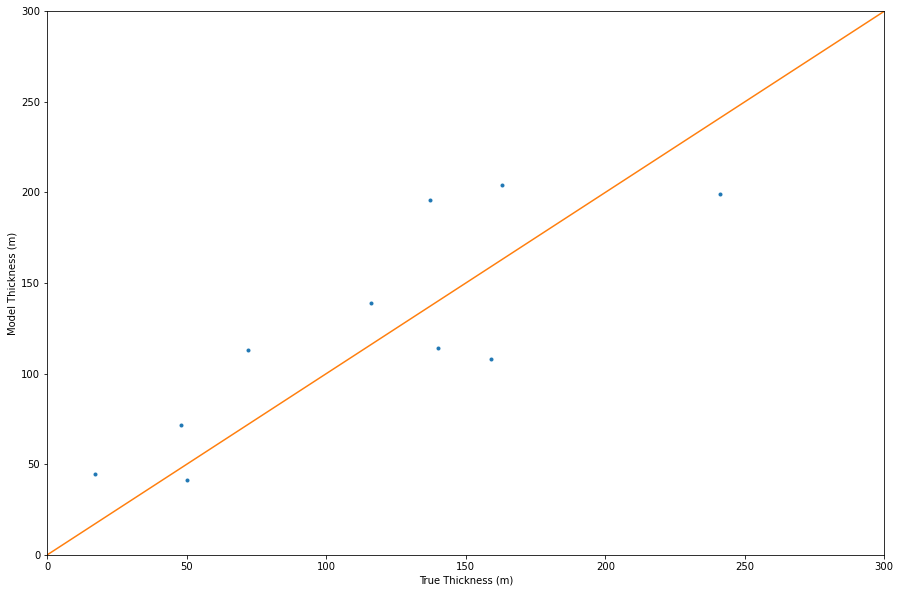

In [5]:
(train_features, test_features,
train_labels, test_labels) = gl.data_splitter(T)
# T_dnn_model = tf.keras.models.load_model(pth_model + 'T_dnn_MULTI')
y = dnn_model['T_MULTI'].predict(test_features)
fig,ax=plt.subplots(1,1,figsize=(15,10))
fig.patch.set_facecolor('w')
plt.plot(test_labels,y,'.')
plt.plot((0,300),(0,300),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,300))
plt.ylim((0,300))

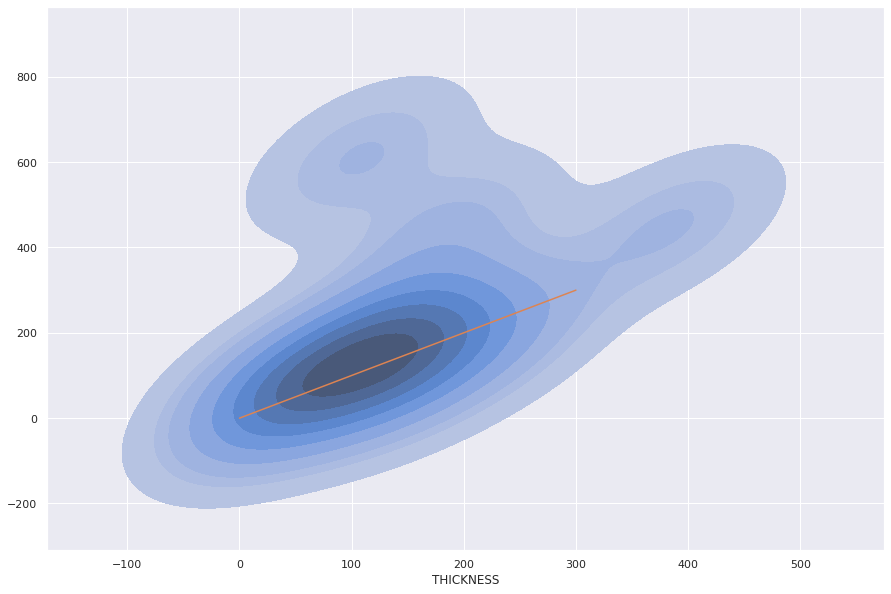

In [6]:
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill=True)
plt.plot((0,300),(0,300),'-')

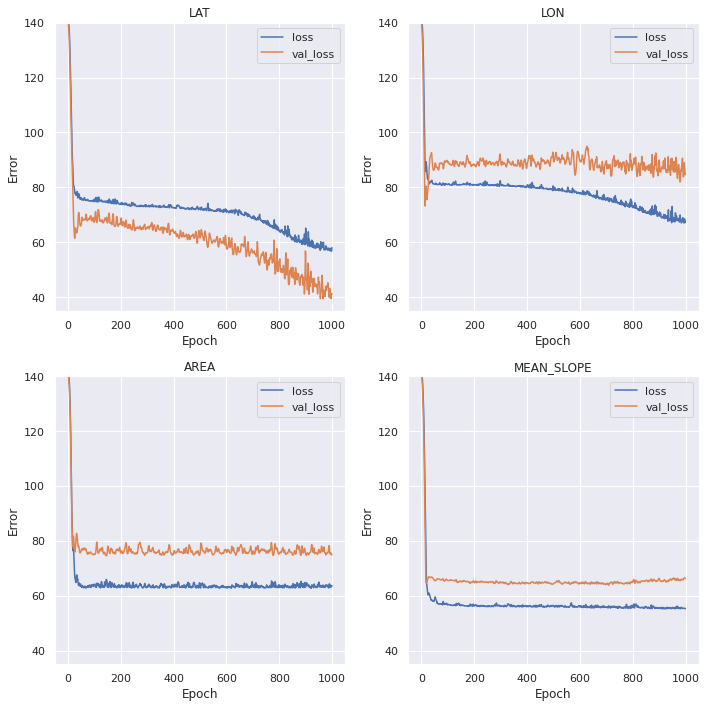

In [7]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
fig.patch.set_facecolor('w')
# gl.plot_loss(dnn_history['T_MULTI'])

for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(2,2,i+1)
    gl.plot_loss(dnn_history['T_'+ variable_name])
    ax.set_ylim([35,140])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()

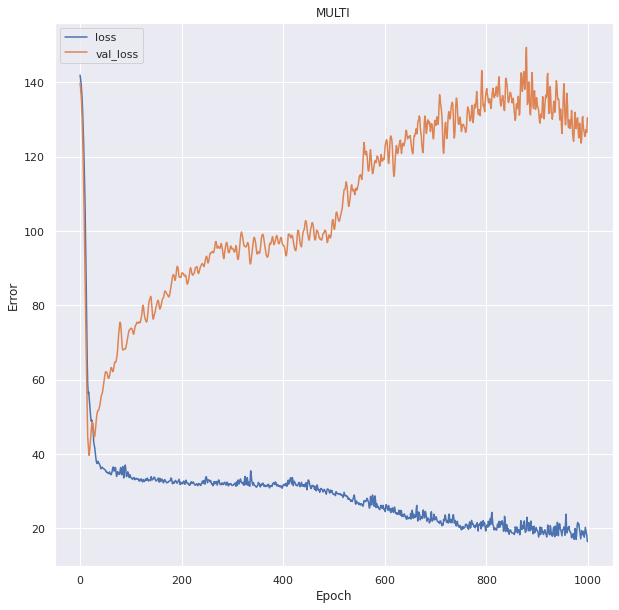

In [8]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
fig.patch.set_facecolor('w')
ax.set_title('MULTI')
gl.plot_loss(dnn_history['T_MULTI'])

(0.0, 300.0)

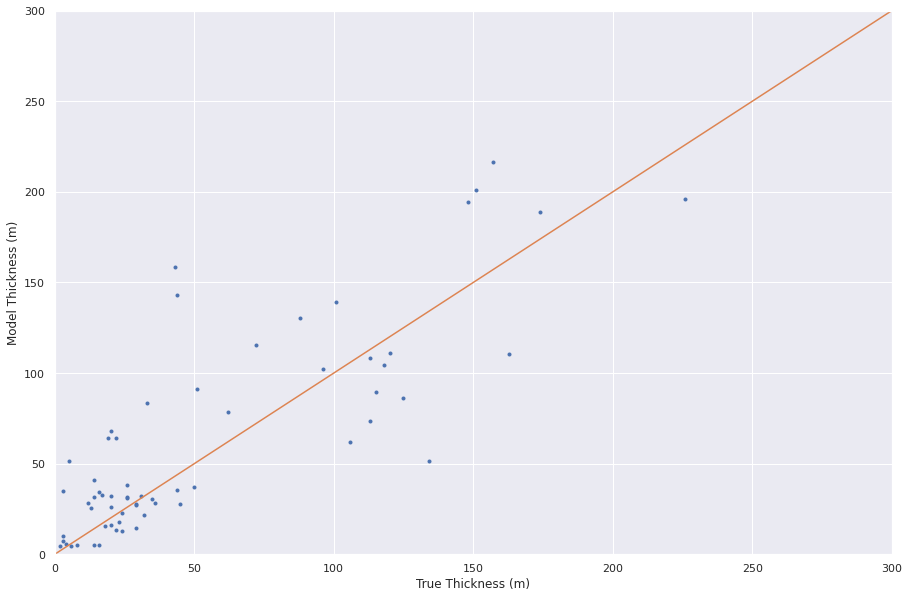

In [9]:
(train_features, test_features,
train_labels, test_labels) = gl.data_splitter(TT)
y = dnn_model['TT_MULTI'].predict(test_features)
fig,ax=plt.subplots(1,1,figsize=(15,10))
fig.patch.set_facecolor('w')
plt.plot(test_labels,y,'.')
plt.plot((0,300),(0,300),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,300))
plt.ylim((0,300))


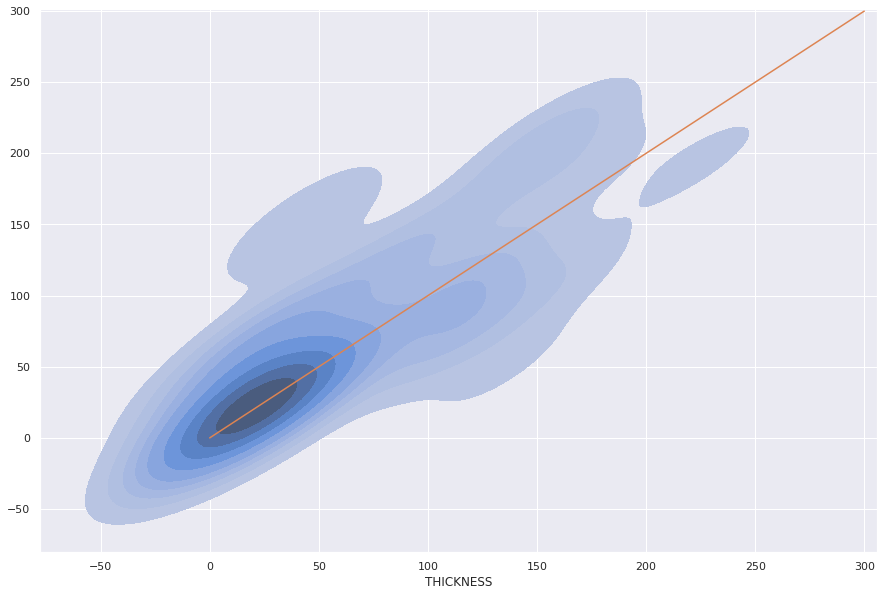

In [10]:
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,300),(0,300),'-')

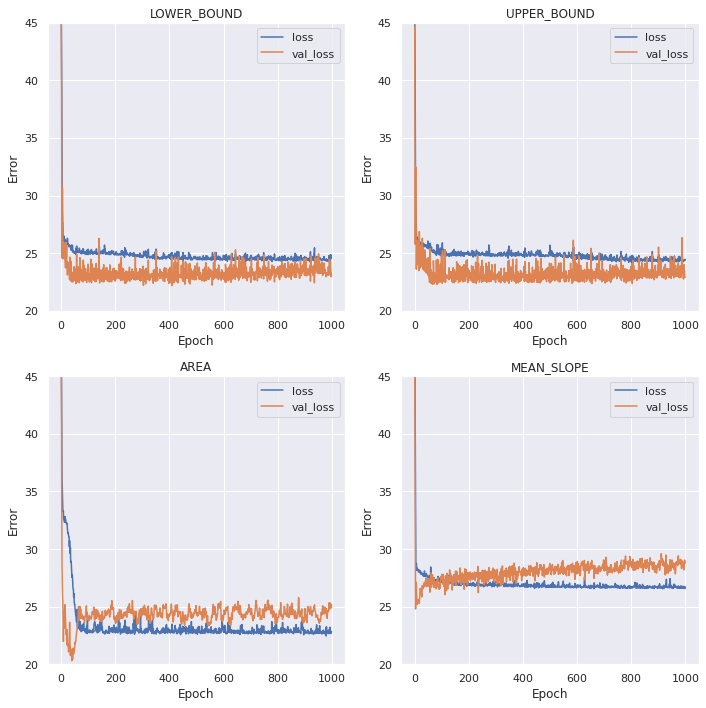

In [11]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
fig.patch.set_facecolor('w')
# gl.plot_loss(dnn_history['TT_MULTI'])

for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(2,2,i+1)
    gl.plot_loss(dnn_history['TT_'+ variable_name])
    ax.set_ylim([20,45])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()


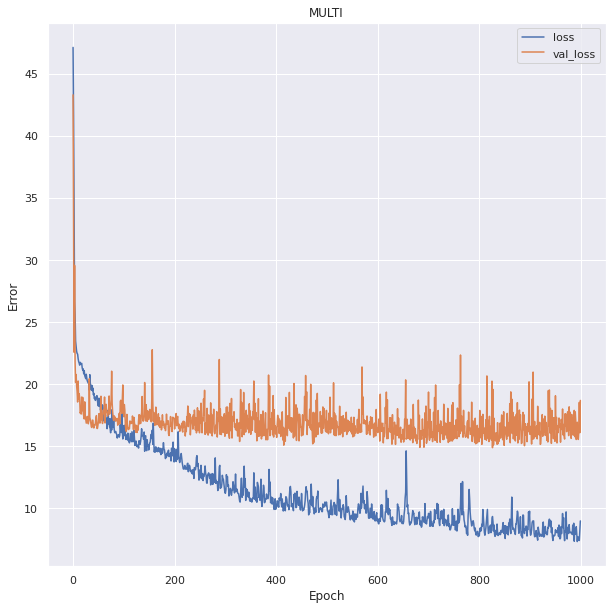

In [12]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
fig.patch.set_facecolor('w')
ax.set_title('MULTI')
gl.plot_loss(dnn_history['TT_MULTI'])

(0.0, 1300.0)

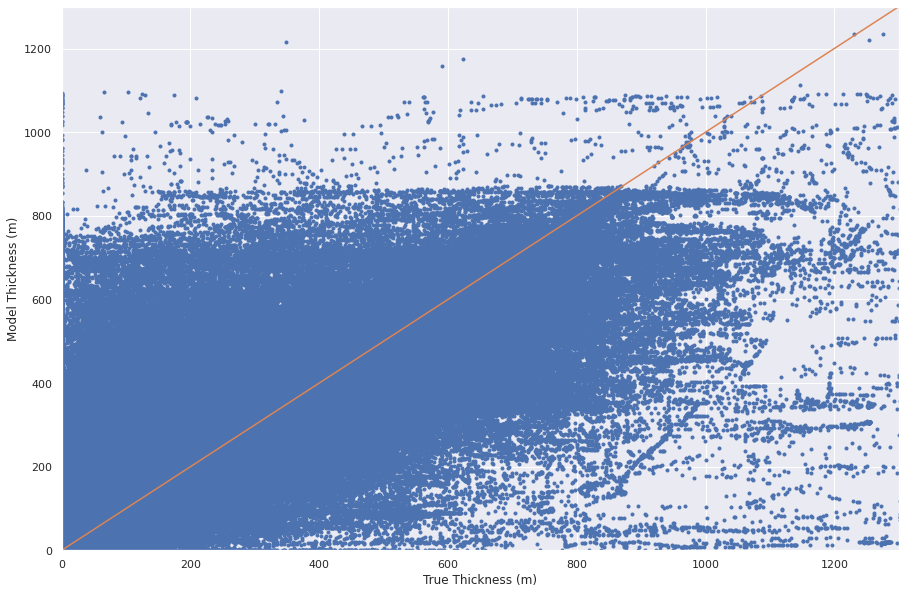

In [13]:
(train_features, test_features,
train_labels, test_labels) = gl.data_splitter(TTT)
y = dnn_model['TTT_MULTI'].predict(test_features)
fig,ax=plt.subplots(1,1,figsize=(15,10))
fig.patch.set_facecolor('w')
plt.plot(test_labels,y,'.')
plt.plot((0,1300),(0,1300),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,1300))
plt.ylim((0,1300))

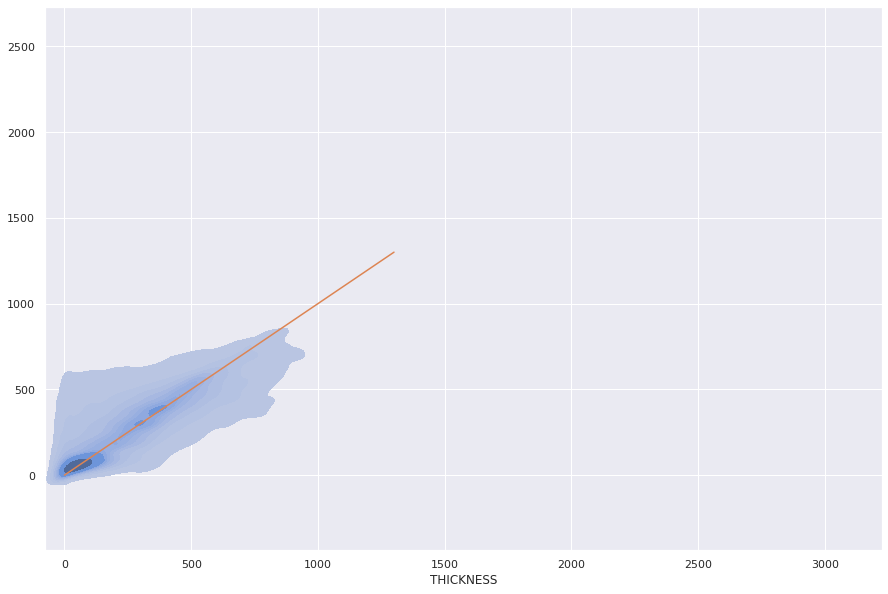

In [14]:
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,1300),(0,1300),'-')

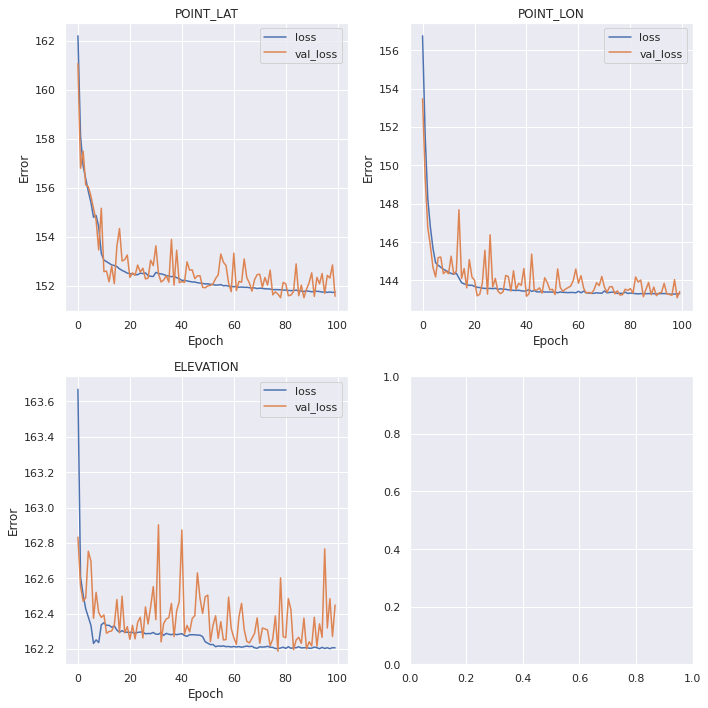

In [15]:

fig,ax=plt.subplots(2,2,figsize=(10,10))
fig.patch.set_facecolor('w')
# gl.plot_loss(dnn_history['TT_MULTI'])

for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(2,2,i+1)
    gl.plot_loss(dnn_history['TTT_'+ variable_name])
#     ax.set_ylim([5,45])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()

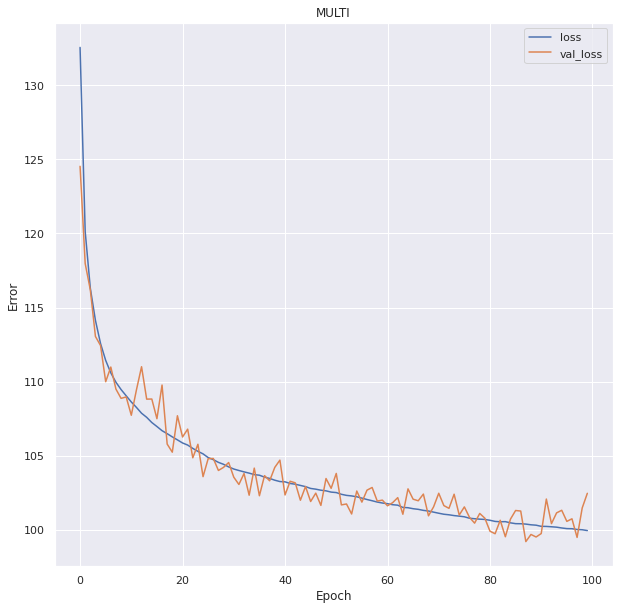

In [16]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
fig.patch.set_facecolor('w')
ax.set_title('MULTI')
gl.plot_loss(dnn_history['TTT_MULTI'])

(0.0, 300.0)

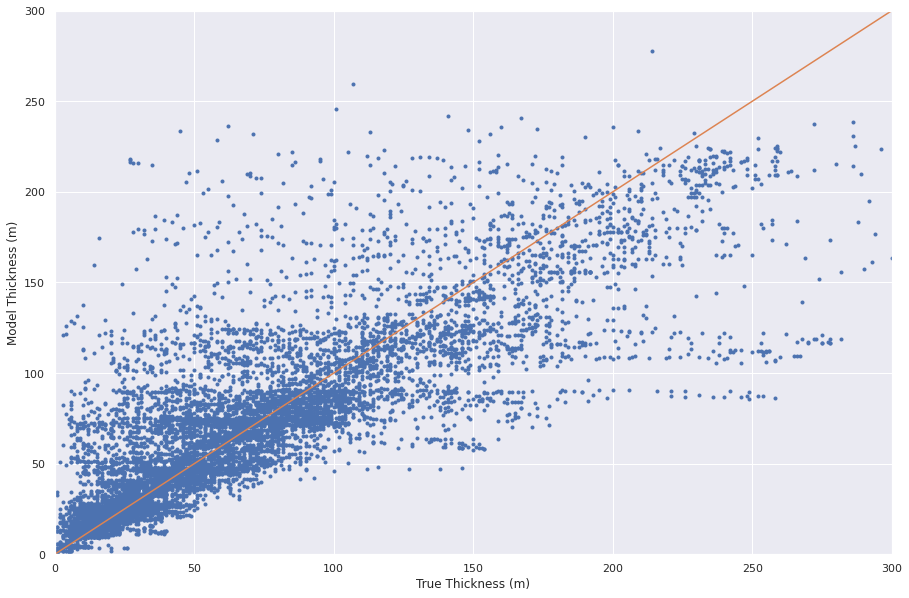

In [17]:
(train_features, test_features,
train_labels, test_labels) = gl.data_splitter(TTTx)
y = dnn_model['TTTx_MULTI'].predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,300),(0,300),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,300))
plt.ylim((0,300))

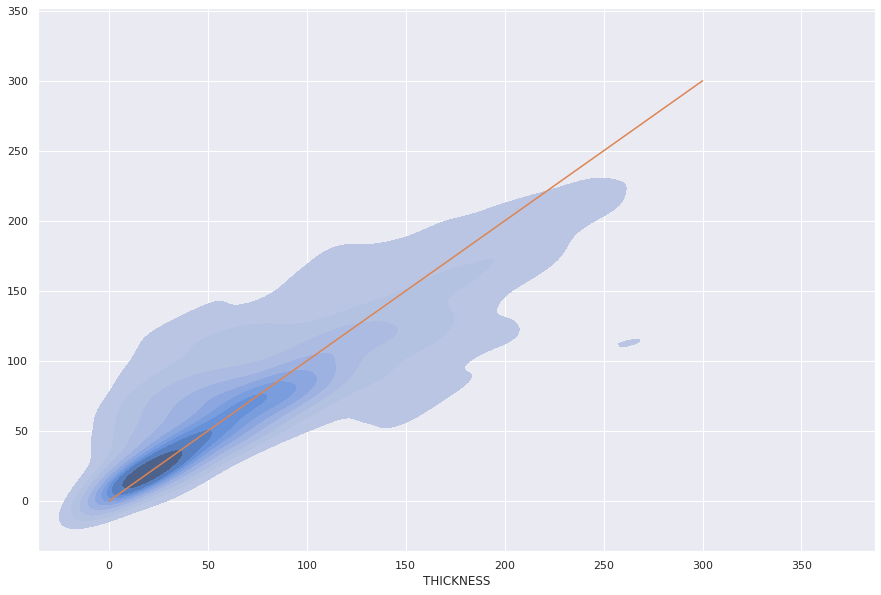

In [20]:
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,300),(0,300),'-')

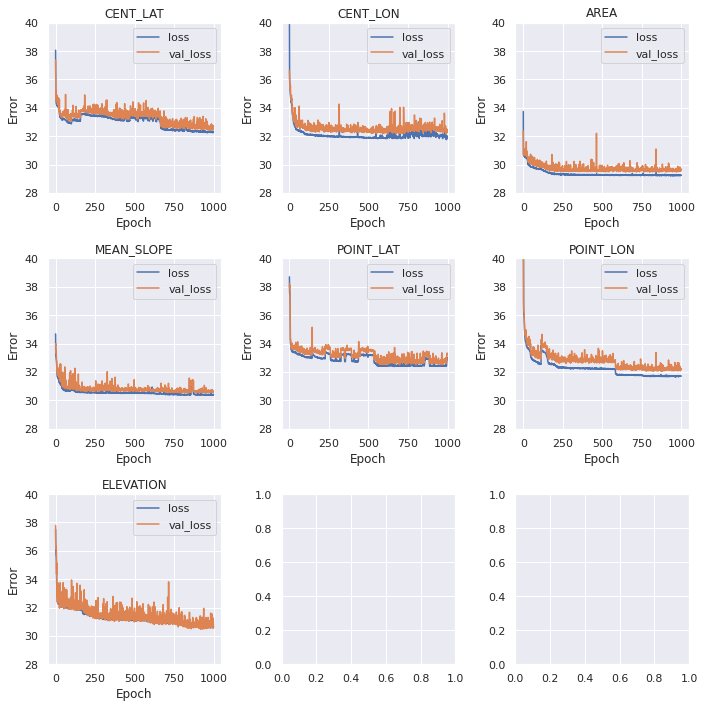

In [21]:
fig,ax=plt.subplots(3,3,figsize=(10,10))
fig.patch.set_facecolor('w')
# gl.plot_loss(dnn_history['TT_MULTI'])

for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(3,3,i+1)
    gl.plot_loss(dnn_history['TTTx_'+ variable_name])
    ax.set_ylim([28,40])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()

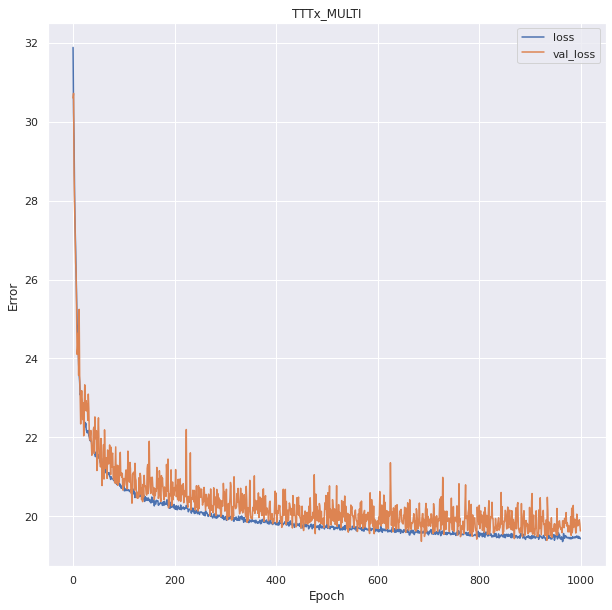

In [22]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
fig.patch.set_facecolor('w')
ax.set_title('TTTx_MULTI')
gl.plot_loss(dnn_history['TTTx_MULTI'])